# Домашнее задание состоит в следующем:

необходимо сформировать функцию управления летательным аппаратом (ЛА). Оптимизировать тяговременные и массовые характеристики ЛА для достижения максимальной дальности полета (при заданных ограничениях). 
Подробности:
ЛА представляет собой материальное тело, движущиеся в вертикальной плоскости. На ЛА действуют:
- сила тяжести, направленная вертикально вниз.  Ускорение свободного падения считается постоянным.
- сила тяги двигателя. Двигатель представляет собой двухрежимную установку. Вы можете перераспределять массы топлива первого и второго режима, а также регулировать уровень тяги на этих режимах. Суммарная масса топлива не может быть больше некоторого значения. 
- аэродинамические силы, такие как лобовое сопротивление и подъемная сила. Силы зависят от скорости и от угла атаки ЛА, а также от плотности воздуха. Плотность воздуха уменьшается с высотой. 

Ограничения для оптимальной траектории:
- скорость ЛА у цели не должна быть меньше 350 м/с;
- угол подлета ЛА к цели (угол тангажа) не должен быть меньше 45 градусов;
- дальность полета ЛА должна быть не менее 60 км.
![](1.png)

### Пример использования "готовой библиотеки"

In [1]:
from rocketlib import Rocket, throw_foo 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
opts = {
    'theta': 45,  # начальный угол тангажа, град
    'P1': 5000,   # тяга на стартовом участке, Н
    'P2': 2000,   # тяга на маршевом участке, Н
    'omega1': 10, # масса топлива на стартовом участке, кг
    'omega2': 20  # масса топлива на маршевом участке, кг
}

def foo(*args):
    return 3

r = Rocket(opts, foo)

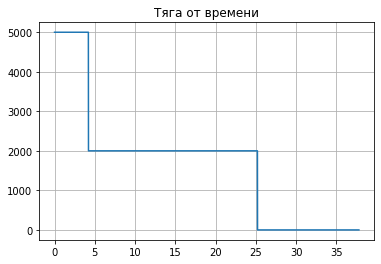

In [4]:
ts = np.linspace(0,1.5*(r.t1+r.t2),10000)
plt.plot(ts, r.get_P(ts))
plt.grid()
plt.title('Тяга от времени')
plt.show()

In [5]:
print(f'Времена работы стартового реима и маршевого: {r.t1}, {r.t2}')

Времена работы стартового реима и маршевого: 4.2, 21.0


Некоторые характеристики/параметры ракеты:
```python
    P_MAX = 5000          # максимальная тяга, Н
    OMEGA_SUM_MAX = 30    # максимальная суммарная масса топлива, кг
    ALPHA_MAX = 10        # максимальный угол атаки, град
    VEL_0 = 30            # начальная скорость
    I_1 = 2100            # удельный импульс топлива, м/с
    MASS_GOOD = 40        # масса полезной нагрузки, кг
    BETA = 1.3            # коэффициент массового совершенства двигательной установки
    D = 100e-3            # калибр, м
```

In [6]:
# "добраться" до этих значений
r.OMEGA_SUM_MAX

30

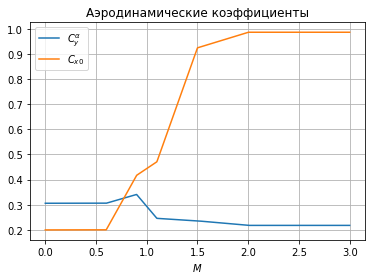

In [7]:
Ms = np.linspace(0,3,1000)
plt.plot(Ms, r.get_Cya(Ms), label=r'$C^\alpha_{y}$')
plt.plot(Ms, r.get_Cx0(Ms), label='$C_{x0}$')
plt.grid()
plt.title('Аэродинамические коэффициенты')
plt.legend()
plt.xlabel('$M$')
plt.show()

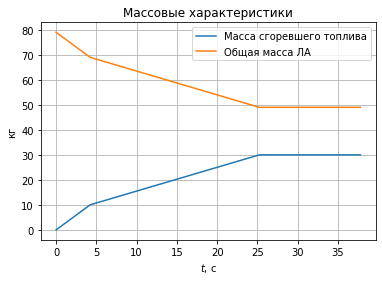

In [8]:
plt.plot(ts, r.get_omega(ts), label=r'Масса сгоревшего топлива')
plt.plot(ts, r.mass0 - r.get_omega(ts), label='Общая масса ЛА')
plt.grid()
plt.title('Массовые характеристики')
plt.legend()
plt.xlabel('$t$, с')
plt.ylabel('кг')
plt.show()

### Как запускать ракету

In [9]:
opts = {
    'theta': 45,
    'P1': 5000,
    'P2': 2000,
    'omega1': 10,
    'omega2': 20
}

def foo(*args):
    return 0

res = throw_foo(opts, foo) 

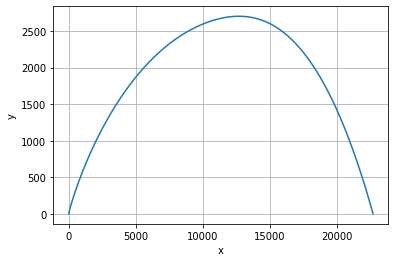

In [10]:
plt.plot(res['x'], res['y'])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

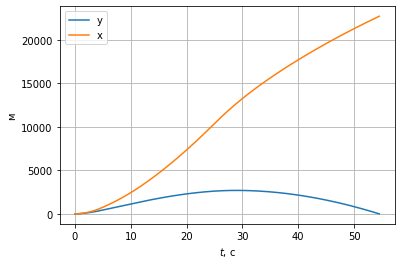

In [11]:
plt.plot(res['t'], res['y'], label='y')
plt.plot(res['t'], res['x'], label='x')
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('м')
plt.legend()
plt.show()

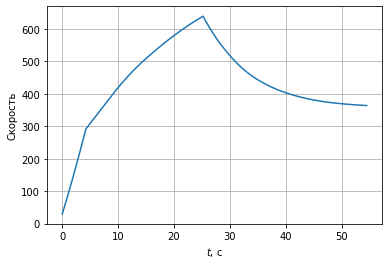

In [12]:
plt.plot(res['t'], res['v'])
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('Скорость')
plt.show()

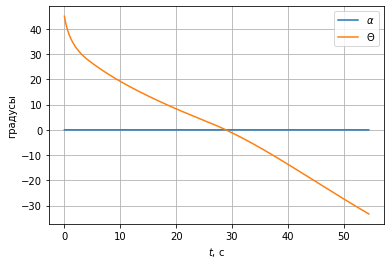

In [13]:
plt.plot(res['t'], res['alpha'], label=r'$\alpha$')
plt.plot(res['t'], res['theta'], label=r'$\Theta$')
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('градусы')
plt.legend()
plt.show()

In [14]:
res.keys()

dict_keys(['v', 'x', 'y', 'theta', 'P', 'm', 'rho', 'M', 'Cya', 'Cx0', 'alpha', 'Cx', 't'])

### Пример оптимизации

In [15]:
from scipy.optimize import differential_evolution

mins = np.array([45, 1, 1, 0.01])
maxes= np.array([85, Rocket.P_MAX, Rocket.P_MAX, 0.99])
#     0 < x[i] < 1
    
#     theta 10..75
#     P1 = 100..5000
#     P2 = 100..5000
#     om_port = 0.1, 0.9

def denormalize(x):
    return mins + x*(maxes-mins)

def normalize(x):
    return (x - mins) / (maxes-mins)

history = []

def minimize_foo(x):
    def my_alpha_foo(t, v, x, y, theta, P, m, rho, M, Cya, Cx0, Sm):
        if theta >0:
            return 0
        return 2
    point = denormalize(x)
    theta, P1, P2, om_port = point
    opts = {
        'theta': theta,
        'P1': P1,
        'P2': P2,
        'omega1': Rocket.OMEGA_SUM_MAX * om_port,
        'omega2': Rocket.OMEGA_SUM_MAX - Rocket.OMEGA_SUM_MAX * om_port
    }
    res = throw_foo(opts, my_alpha_foo) 
    crit = res['x'][-1]
    history.append((crit, point))
    return -crit

bounds = [(0,1),(0,1),(0,1),(0,1)]

In [17]:
result = differential_evolution(minimize_foo, bounds, maxiter=10)

Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли управление
Ошибка, мы слишком замедлились и потеряли упра

In [18]:
result

     fun: -44066.68930913605
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 960
     nit: 10
 success: False
       x: array([0.76089074, 0.95645022, 0.15504595, 0.43235651])

In [19]:
len(history)

1855

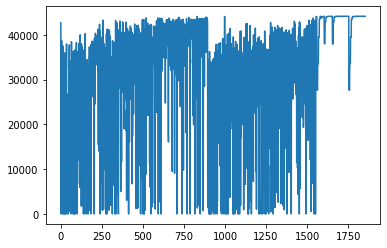

In [20]:
plt.plot([crit for crit, point in history])

In [22]:
point = denormalize(result.x)
theta, P1, P2, om_port = point
theta, P1, P2, om_port

(75.4356296771181, 4782.294652393352, 776.0747069517862, 0.4337093803741513)

In [24]:
point = denormalize(result.x)
theta, P1, P2, om_port = point
opts = {
    'theta': theta,
    'P1': P1,
    'P2': P2,
    'omega1': Rocket.OMEGA_SUM_MAX * om_port,
    'omega2': Rocket.OMEGA_SUM_MAX - Rocket.OMEGA_SUM_MAX * om_port
}
def my_alpha_foo(t, v, x, y, theta, P, m, rho, M, Cya, Cx0, Sm):
    if theta >0:
        return 0
    return 2
res = throw_foo(opts, my_alpha_foo) 

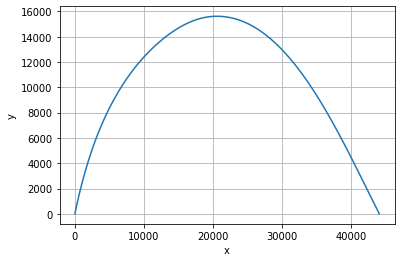

In [25]:
plt.plot(res['x'], res['y'])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

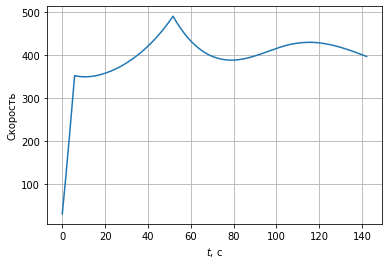

In [26]:
plt.plot(res['t'], res['v'])
plt.grid()
plt.xlabel('$t$, с')
plt.ylabel('Скорость')
plt.show()